In [5]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt

import seaborn as sns



In [13]:
# Set Matplotlib defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [3]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [2]:
SEED = 1
random.seed(SEED)
np.random.seed(SEED)

In [15]:
Kenya = pd.read_csv("GeoAI/Agricultural Plastic/Data/Kenya_training.csv")
Spain =  pd.read_csv("GeoAI/Agricultural Plastic/Data/Spain_training.csv")
VNM =  pd.read_csv("GeoAI/Agricultural Plastic/Data/VNM_training.csv")
VNM.rename(columns={'Lat': 'lat', 'Lon': 'lon'}, inplace=True)
df = pd.concat([Kenya, Spain, VNM], axis=0)

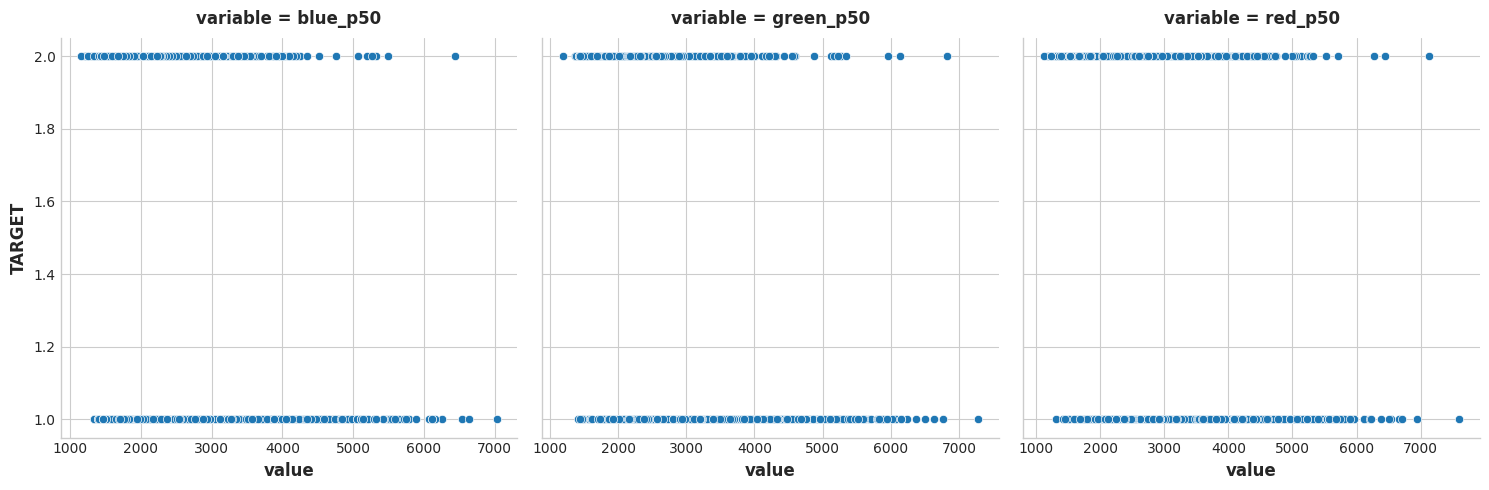

In [16]:
features = ['blue_p50', 'green_p50','red_p50']
sns.relplot(
    x="value", y="TARGET", col="variable", data=df.melt(id_vars="TARGET", value_vars=features), facet_kws=dict(sharex=False),
);

In [9]:
y_ = df['TARGET']-1
X_ = df[['lat', 'lon', 'blue_p50', 'green_p50', 'nir_p50', 'nira_p50', 're1_p50', 're2_p50', 
         're3_p50', 'red_p50', 'swir1_p50', 'swir2_p50', 'VV_p50', 'VH_p50']]

In [10]:
X_train, X_eval, y_train, y_eval = train_test_split(X_, y_, test_size=0.1, random_state=1)

In [11]:
from sklearn.ensemble import RandomForestClassifier

RFR = RandomForestClassifier()
RFR.fit(X_train, y_train)
RFR.score(X_eval, y_eval)

0.9611307420494699

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

GBR = GradientBoostingClassifier()
GBR.fit(X_train, y_train)
GBR.score(X_eval, y_eval)

0.9646643109540636

In [13]:
from catboost import CatBoostClassifier

CAT = CatBoostClassifier()
CAT.fit(X_train, y_train, silent=True)
print(CAT.score(X_eval, y_eval))

0.9717314487632509


In [14]:
from lightgbm import LGBMClassifier

LGB = LGBMClassifier(force_col_wise=True)
LGB.fit(X_train, y_train)
print(LGB.score(X_eval, y_eval))

[LightGBM] [Info] Number of positive: 1324, number of negative: 1218
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 2542, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.520850 -> initscore=0.083447
[LightGBM] [Info] Start training from score 0.083447
0.9752650176678446


In [15]:
from xgboost import XGBClassifier
XGB = XGBClassifier()
XGB.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=False)
print(XGB.score(X_eval, y_eval))

0.9752650176678446


### Test with Eval

In [16]:
from sklearn.metrics import accuracy_score

rfr  = RFR.predict(X_eval)
gbr  = GBR.predict(X_eval)
cat  = GBR.predict(X_eval)
lgb = LGB.predict(X_eval)
xgb = XGB.predict(X_eval)
pred = np.round((rfr+gbr+cat+lgb+xgb)/5,0).astype(int)
print(accuracy_score(y_eval, pred))

rfr  = RFR.predict(X_eval)*0.96
gbr  = GBR.predict(X_eval)*0.96
cat  = GBR.predict(X_eval)*0.97
lgb = LGB.predict(X_eval)*0.98
xgb = XGB.predict(X_eval)*0.98
pred = np.round((rfr+gbr+cat+lgb+xgb)/(0.96+0.96+0.97+0.98+0.98)).astype(int)
print(accuracy_score(y_eval, pred))


rfr  = RFR.predict_proba(X_eval)*0.96
gbr  = GBR.predict_proba(X_eval)*0.96
cat  = GBR.predict_proba(X_eval)*0.97
lgb = LGB.predict_proba(X_eval)*0.98
xgb = XGB.predict_proba(X_eval)*0.98
pred = (rfr+gbr+cat+lgb+xgb)/(0.96+0.96+0.97+0.98+0.98)
pred = np.argmax(pred, axis=1)
print(accuracy_score(y_eval, pred))


0.9681978798586572
0.9681978798586572
0.9752650176678446


## Submission

In [17]:
Kenya = pd.read_csv("GeoAI/Agricultural Plastic/Data/Kenya_testing.csv")
Spain =  pd.read_csv("GeoAI/Agricultural Plastic/Data/Spain_validation.csv")
VNM =  pd.read_csv("GeoAI/Agricultural Plastic/Data/VNM_testing.csv")
VNM.rename(columns={'Lon': 'lon', 'Lat': 'lat'}, inplace=True)

submission = pd.DataFrame()
country = ['Kenya', 'Spain', 'VNM']
files = [Kenya, Spain, VNM]

In [18]:
for i in range(3):
    tmp = pd.DataFrame()
    # Create ID for submission file
    ID = [country[i] + '_' + str(x) for x in files[i]['ID']]
    # Predict
    X_ = files[i][['lat', 'lon', 'blue_p50', 'green_p50', 'nir_p50', 'nira_p50', 're1_p50', 're2_p50', 
         're3_p50', 'red_p50', 'swir1_p50', 'swir2_p50', 'VV_p50', 'VH_p50']]
    rfr  = RFR.predict_proba(X_)*0.96
    gbr  = GBR.predict_proba(X_)*0.96
    cat  = GBR.predict_proba(X_)*0.97
    lgb = LGB.predict_proba(X_)*0.98
    xgb = XGB.predict_proba(X_)*0.98

    pred = (rfr+gbr+cat+lgb+xgb)/(0.96+0.96+0.97+0.98+0.98)
    pred = np.argmax(pred, axis=1)
    TARGET = pred+1
    
    tmp["ID"] = ID
    tmp["TARGET"] = TARGET
    submission = pd.concat([submission, tmp], axis=0)


## Verificacao

In [23]:
import os
import pandas as pd

output_dir = 'GeoAI/Agricultural Plastic/Data/output'
os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
output_file = os.path.join(output_dir, 'sub_0208_1150.csv')

# Save to CSV
submission.to_csv(output_file, index=False)
print(f"CSV file saved to: {output_file}")

CSV file saved to: GeoAI/Agricultural Plastic/Data/output/sub_0208_1150.csv


In [22]:
#submission.to_csv('GeoAI/Agricultural Plastic/Data/sub_0208_1150.csv',index=False)
submission.to_csv('GeoAI/Agricultural Plastic/Data/output/sub_0208_1150.csv', index=False)

OSError: Cannot save file into a non-existent directory: 'GeoAI/Agricultural Plastic/Data/output'

In [59]:
consolidado_0 = pd.read_csv('./Data/submission_0208_1150.csv')
consolidado_2 = pd.read_csv('GeoAI/Agricultural Plastic/Data/submission_2.csv')

c = pd.DataFrame()
c['s0'] = consolidado_0['TARGET']
c['s2'] = consolidado_2['TARGET']

c['diferente'] = (c['s0'] != c['s2'])

# Contando quantas vezes os valores são diferentes
num_dif = c['diferente'].sum()
num_dif

num_dif/c.shape[0]

0.007779349363507779

In [60]:
submission.shape

(2828, 2)